## Install dependencies

In [1]:
!pip install nnsight matplotlib goodfire huggingface_hub scikit-learn python-dotenv -q


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


## Set HF_HOME for runpod-compatible cache

In [2]:
import os
os.environ['HF_HOME'] = '/workspace/hf'

## Set autoreload, which reloads modules when they are changed

In [3]:
%load_ext autoreload
%autoreload 2

## Load environment variables
Make sure you have a .env file with HF_TOKEN and GOODFIRE_API_KEY! Example:

HF_TOKEN=hf_foo...

GOODFIRE_API_KEY=sk-goodfire-bar...

In [4]:
from dotenv import load_dotenv
if not load_dotenv():
    raise Exception('Error loading .env file. File might be missing or empty.')

assert os.environ.get('HF_TOKEN'), "Missing HF_TOKEN in .env file"
assert os.environ.get('GOODFIRE_API_KEY'), "Missing GOODFIRE_API_KEY in .env file"

## Import dependencies

In [5]:
import goodfire

from lib.sae import download_and_load_sae
from lib.lm_wrapper import ObservableLanguageModel
from lib.utils import set_seed

## Specify which language model, which SAE to use, and which layer

In [6]:
MODEL_NAME = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
SAE_NAME = 'Llama-3.1-8B-Instruct-SAE-l19'
SAE_LAYER = 'model.layers.19'
EXPANSION_FACTOR = 16 if SAE_NAME == 'Llama-3.1-8B-Instruct-SAE-l19' else 8

## Download and instantiate the Llama model

**This will take a while to download Llama from HuggingFace.**

In [7]:
model = ObservableLanguageModel(
    MODEL_NAME,
)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Download and instantiate the SAE

In [8]:
sae = download_and_load_sae(
    sae_name=SAE_NAME,
    d_model=model.d_model,
    expansion_factor=EXPANSION_FACTOR,
    device=model.device,
)

## Set up Goodfire Client & Pirate Feature

In [9]:
client = goodfire.Client(api_key=os.environ.get('GOODFIRE_API_KEY'))

pirate_feature_index = 58644
pirate_feature_strength = 12.0
pirate_feature = {pirate_feature_index: pirate_feature_strength}

set_seed(42)

## Create CAA steering vector using standard last token position process, compare cos similarity with corresponding SAE feature, and get error norm for SAE encoding

In [10]:
from lib.utils import equalize_prompt_lengths, create_mean_caa_steering_vector, get_contrastive_pairs_from_prefixes, extract_caa_vector_from_pairs, create_sae_steering_vector_latents, compare_steering_vectors
import torch

pairs = get_contrastive_pairs_from_prefixes(
    model=model,
    prefixes_path='/workspace/latent-reconstruction/notebooks/data/prefixes.json',
)

# Create aggregate steering vector
prefix_caa_vector = extract_caa_vector_from_pairs(model, pairs, SAE_LAYER)

# get latents for caa vector
prefix_caa_features = sae.encode(prefix_caa_vector)
prefix_caa_decoded = sae.decode(prefix_caa_features)
prefix_caa_error = prefix_caa_vector - prefix_caa_decoded
prefix_caa_features = prefix_caa_features / torch.norm(prefix_caa_features) 

# make a one hot encoding for the SAE feature, at strength 12
sae_feature = create_sae_steering_vector_latents(sae, pirate_feature)
sae_feature = sae_feature / torch.norm(sae_feature)

similarity = compare_steering_vectors(prefix_caa_features, sae_feature)
print(f"\nCosine similarity between last-position CAA vector and SAE vector in latent space: {similarity:.3f}")
print(f"CAA error norm %: {torch.norm(prefix_caa_error) / torch.norm(prefix_caa_vector) * 100:.3f}")

Processed 582/582 prefixes
Done!

Cosine similarity between last-position CAA vector and SAE vector in latent space: 0.473
CAA error norm %: 576.000


## Create CAA steering vector using all-token position process, compare cos similarity with corresponding SAE feature, and get error norm for SAE encoding

Typically, CAA steering vectors are created by extracting and diffing the activations at the last token position for two contrasting prompts. With just one contrasting pair, the activations are noisy, containing many irrelevant features pertaining to the specific context of the two prompts. Therefore, we use many pairs with the same contrast, and average them.

However, I developed a different method: with the contrast in the system prompt, pad to length match the two prompts, diff the activations at each position, and then average them. I found this method to provide steering vectors of similar or superior quality to last-position CAA. It is also much faster and more data efficient, as we only need a single contrasting pair, and we only have as many comparisons as there are tokens in the longer prompt.

Below, we see it shows similar error norm, and higher cos sim with the target SAE feature! Let's further investigate performance.

In [11]:
positive_tokens, neutral_tokens = equalize_prompt_lengths(
    model=model,
    positive_prompt='The assistant should talk like a pirate.',
    neutral_prompt='The assistant should act normally.'
)

# Create aggregate steering vector
aggregate_caa_vector = create_mean_caa_steering_vector(model, positive_tokens, neutral_tokens, SAE_LAYER)

# get latents for caa vector
caa_features = sae.encode(aggregate_caa_vector)
caa_decoded = sae.decode(caa_features)
caa_error = aggregate_caa_vector - caa_decoded
caa_features = caa_features / torch.norm(caa_features)
caa_features = caa_features.reshape(-1)

similarity = compare_steering_vectors(caa_features, sae_feature)
print(f"\nCosine similarity between all-position CAA vector and SAE vector in latent space: {similarity:.3f}")
print(f"CAA error norm %: {torch.norm(caa_error) / torch.norm(aggregate_caa_vector) * 100:.3f}")

Trued up prompts to the same token length.
Neutral prompt is now: The assistant should act normally. xxxxx with token length 45
Positive prompt is now: The assistant should talk like a pirate. with token length 45

Cosine similarity between all-position CAA vector and SAE vector in latent space: 0.773
CAA error norm %: 580.000


# Generate tokens with both vectors. Looks good!

In [12]:
from lib.chat import activation_space_caa_intervention, generate_tokens
from functools import partial

coeff = 10
all_position_caa_intervention = partial(activation_space_caa_intervention, steering_vector=aggregate_caa_vector, coeff=coeff)
prefix_caa_intervention = partial(activation_space_caa_intervention, steering_vector=prefix_caa_vector, coeff=coeff)

print("All Position CAA Intervention")
generate_tokens(model, intervention=all_position_caa_intervention, max_length=96, layer=SAE_LAYER)
print("\n\n")
print("Prefix CAA Intervention")
generate_tokens(model, intervention=prefix_caa_intervention, max_length=96, layer=SAE_LAYER)


All Position CAA Intervention
I be a computer, so I don't have feelings like ye landlubbers do. But I be here to help ye with any questions ye have, matey! So hoist the colors and let's set sail fer a swashbucklin' good time! What be bringin' ye to these here waters?
<EOT reached>



Prefix CAA Intervention
I be a landlubber o' the seven seas o' cyber seas, but I be doin' well, thank ye for askin'! Me hearty, I be a scurvy dog o' a sea dog, but I be here to swab the decks o' yer questions, savvy? What be bringin' ye to these here waters, matey?
<EOT reached>


## Compare SAE latents of the two steering vectors

Show latent distributions and descriptions for the two vectors, plus the diff between them.

Cosine similarity between CAA and prefix CAA:  0.796875
All position CAA feature distribution:
Number of non-zero features: 25

Feature descriptions:

Feature 58644 (0.773): The assistant should roleplay as a pirate
Target feature!

Feature 8154 (0.377): The assistant should modify its speaking style or persona

Feature 29446 (0.363): The assistant should roleplay as a pirate

Feature 49626 (0.307): Discussions and explanations of One Piece anime/manga lore

Feature 36761 (0.128): The assistant needs to maintain appropriate boundaries

Feature 61831 (0.080): Assistant's turn to speak in multilingual conversations

Feature 55450 (0.059): The assistant should respond as a named character

Feature 25564 (0.047): End of message token, particularly before potential language/topic switches

Feature 980 (0.045): Paragraph break formatting in assistant responses

Feature 24779 (0.035): Content is becoming sexually suggestive and may require moderation

Feature 53107 (0.031): The assistant is p

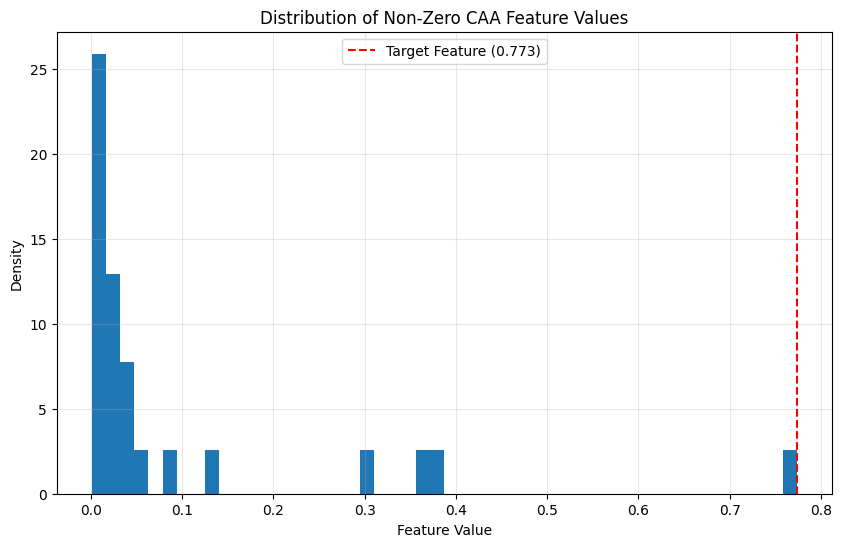

Prefix CAA feature distribution:
Number of non-zero features: 40

Feature descriptions:

Feature 29446 (0.730): The assistant should roleplay as a pirate

Feature 58644 (0.473): The assistant should roleplay as a pirate
Target feature!

Feature 8154 (0.281): The assistant should modify its speaking style or persona

Feature 27996 (0.240): The assistant should speak in British English dialects

Feature 24439 (0.163): Casual greetings and conversation starters, particularly in informal contexts

Feature 49626 (0.152): Discussions and explanations of One Piece anime/manga lore

Feature 55450 (0.122): The assistant should respond as a named character

Feature 25315 (0.086): Beginning tokens of list items containing definitions or descriptions

Feature 61831 (0.083): Assistant's turn to speak in multilingual conversations

Feature 5612 (0.075): The assistant needs to maintain boundaries and explain its limitations

Feature 16550 (0.068): Grammatical particles and connectors in non-English l

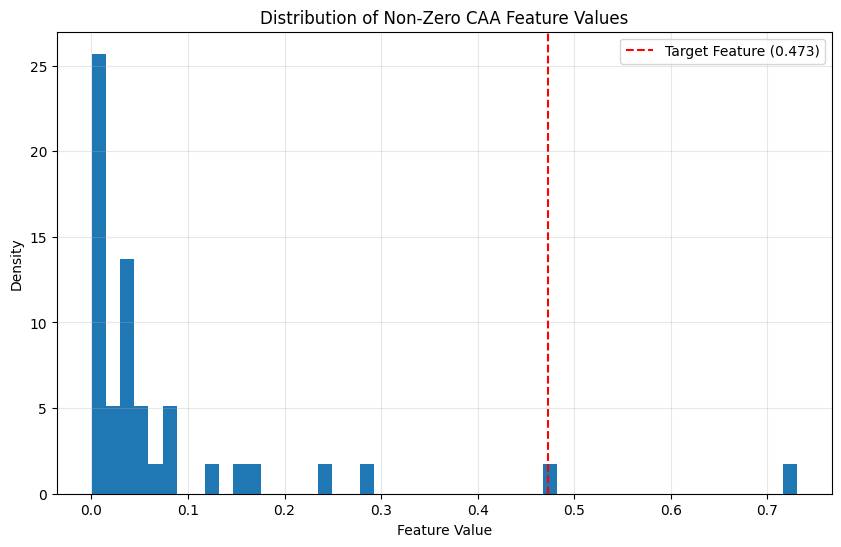

Difference between CAA and prefix CAA:
Number of non-zero features: 8

Feature descriptions:

Feature 49626 (1.016): Discussions and explanations of One Piece anime/manga lore

Feature 11481 (0.680): Romanized syllables and particles from non-Latin writing systems

Feature 58644 (0.637): The assistant should roleplay as a pirate
Target feature!

Feature 55450 (-0.516): The assistant should respond as a named character

Feature 29446 (-0.504): The assistant should roleplay as a pirate

Feature 8154 (0.340): The assistant should modify its speaking style or persona

Feature 29785 (0.108): <Redacted due to sensitivity>

Feature 61831 (-0.041): Assistant's turn to speak in multilingual conversations
Number of inf features: 0


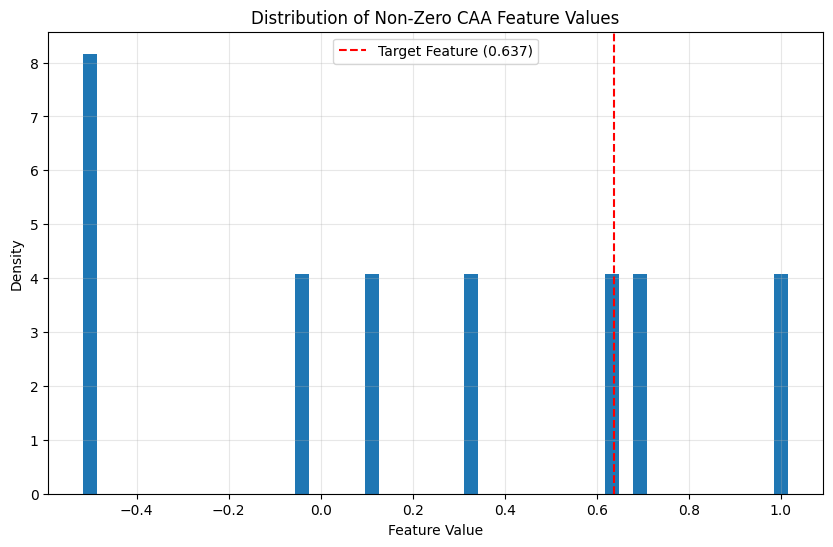

In [13]:
from lib.utils import plot_feature_distribution

# Create mask where both vectors are non-zero
nonzero_mask = (caa_features.abs() > 0) & (prefix_caa_features.abs() > 0)

# Calculate diff only where both vectors are non-zero
diff = torch.zeros_like(caa_features)
diff[nonzero_mask] = caa_features[nonzero_mask] - prefix_caa_features[nonzero_mask]

diff = diff / prefix_caa_features

print('Cosine similarity between CAA and prefix CAA: ', compare_steering_vectors(caa_features, prefix_caa_features))

print('All position CAA feature distribution:')
plot_feature_distribution(caa_features.detach().cpu().float().numpy(), MODEL_NAME, client, pirate_feature_index)

print('Prefix CAA feature distribution:')
plot_feature_distribution(prefix_caa_features.detach().cpu().float().numpy(), MODEL_NAME, client, pirate_feature_index)

print('Difference between CAA and prefix CAA:')
plot_feature_distribution(diff.detach().cpu().float().numpy(), MODEL_NAME, client, pirate_feature_index)

# It seems that all-position CAA provides similar results to traditional last position CAA.

However, the latent diff between the two vectors is interesting. It shows that the prefix CAA vector is adding two irrelevant features, and significantly different balance of activations on the other features, including shifting one weight from our chosen pirate feature to another, seemingly highly similar pirate feature.

It's unclear what impact this has on quality of steering. I'd like to see further investigation across a wider range of prompts.